# Data Exploration: Køge Dataset: ECG

This notebook contains the analysis of the signal data contained by the database provided by Jonas Munch Nielsen who is a PHD student.<br>

<br>
Notice that only files containing seizure timestamp are included.

The outline of this analysis is a follows: <br>

1. Reading and transforming the dataset to pandas Dataframe
2. Taking a look at the different features from the frequency and time domain.
3. Spectral analysis.

## Importing Packages

In [2]:
# What version of Python do you have?
import sys
import os
import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import numpy as np
import re
import mne
import pathlib
import openpyxl
from datetime import datetime
import pytz
import matplotlib
import random
import os
from skimage.restoration import (denoise_wavelet, estimate_sigma)
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Sequential
from matplotlib import pyplot as plt
from scipy import signal
plt.ioff()
from time import gmtime
import psutil
import gc
import glob
plt.style.use('ggplot')

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.7.0
Keras Version: 2.7.0

Python 3.9.7 (default, Sep 16 2021, 23:53:23) 
[Clang 12.0.0 ]
Pandas 1.3.4
Scikit-Learn 1.0.1
GPU is available


In [3]:
cwd = os.getcwd()
database_path = '../../Dataset/EMU_monitor(ruc)/'
save_csv_path = '../../Dataset/EMU_monitor(ruc)/NHR/EEG'
edf_file_type = ".edf"
capitilize_edf_file_type = ".EDF"
bdf_file_type = ".BDF"
patient_one_path = 'chb04/'
info_df_path = "/Users/niklashjort/Desktop/Notes/Speciale/projects/Dataset/EMU_monitor(ruc)/NHR_Eventlist_RUC.xlsx"
external_hardisk_drive_path = os.path.dirname('/Volumes/LaCie/Database/')
cwd

'/Users/niklashjort/Desktop/Notes/Speciale/projects/Master_Thesis_Project/Data_Analysis'

## Data Overview

The data overview is visualized in the "EEG-Dataset-Køge" notebook.

# Reading ECG Data

In [4]:
def ReadEdfFile(file_name, print_reader_info = False):
    if edf_file_type in file_name or capitilize_edf_file_type in file_name:
        if(print_reader_info):
            data = mne.io.read_raw_edf(file_name)
            raw_data = data.get_data()
            converted_raw = pd.DataFrame(raw_data.transpose(), columns=data.ch_names)
            print(data.info)
            return converted_raw, data.info
        else:
            data = mne.io.read_raw_edf(file_name, verbose='error')
            raw_data = data.get_data()
            converted_raw = pd.DataFrame(raw_data.transpose(), columns=data.ch_names)
            return converted_raw, data.info
    if bdf_file_type in file_name:
        if(print_reader_info):
            data = mne.io.read_raw_bdf(file_name)
            raw_data = data.get_data()
            converted_raw = pd.DataFrame(raw_data.transpose(), columns=data.ch_names)
            print(data.info)
            return converted_raw, data.info
        else:
            data = mne.io.read_raw_edf(file_name, verbose='error')
            raw_data = data.get_data()
            converted_raw = pd.DataFrame(raw_data.transpose(), columns=data.ch_names)
            return converted_raw, data.info

In [5]:
df, info = ReadEdfFile("/Users/niklashjort/Desktop/Notes/Speciale/projects/Dataset/EMU_monitor(ruc)/EKG/Patient 4/13-02-00.EDF")

In [6]:
info

<Info | 7 non-empty values
 bads: []
 ch_names: ECG, Accelerometer_X, Accelerometer_Y, Accelerometer_Z, Marker, HRV
 chs: 6 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: 2019-05-22 13:02:00 UTC
 nchan: 6
 projs: []
 sfreq: 500.0 Hz
>

In [7]:
df.head()

,ECG,Accelerometer_X,Accelerometer_Y,Accelerometer_Z,Marker,HRV
0,0.000472,205.000000,-221.000000,-871.500000,0.0,0.0
1,0.000479,205.474173,-229.336367,-868.828262,0.0,0.0
2,0.000496,205.605934,-236.363082,-866.294363,0.0,0.0
3,0.000549,205.406332,-242.092522,-863.965831,0.0,0.0
4,0.000637,204.887758,-246.553938,-861.910898,0.0,0.0


In [8]:
ECG_FREQ = info['sfreq']
meas_timestamp = info['meas_date']

Only the channel "ECG" is useful for further analysis.

In [9]:
df = df['ECG']

In [11]:
gc.collect()
df.head()

0    0.000472
1    0.000479
2    0.000496
3    0.000549
4    0.000637
Name: ECG, dtype: float64

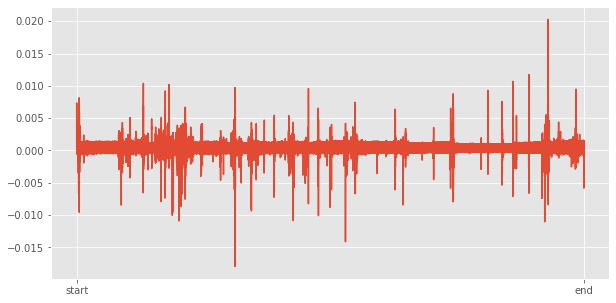

In [17]:
plt.figure(figsize=(10,5), facecolor='w')
plt.plot(df)
my_x_ticks = ['start', "end"]
plt.xticks([0, len(df)], my_x_ticks)
plt.show()

In [18]:
def convert_date_to_ms(date_time):
    date_time = str(date_time)
    if "+" in str(date_time):
        date_time = str(date_time).split("+")[0]
    try:
        timestamp_ms = datetime.utcnow().strptime(date_time, '%Y-%m-%d %H:%M:%S').timestamp() * 1000
    except:
        timestamp_ms = datetime.utcnow().strptime(date_time, '%d-%m-%Y %H:%M:%S').timestamp() * 1000
    return timestamp_ms

In [19]:
file_meas_start = convert_date_to_ms(meas_timestamp)
file_meas_start

1558522920000.0

In [20]:
datetime.fromtimestamp(file_meas_start/1000.0)

datetime.datetime(2019, 5, 22, 13, 2)

In [22]:
def insert_time_stamp(dataframe, file_start_time, frq, date_converter):
    timestamp_ms = date_converter(file_start_time)
    period_row_increment_value =  (1 / int(frq)) * 1000
    dataframe.insert(0, "timestamp", [timestamp_ms + i * period_row_increment_value for i in dataframe.index])

In [23]:
df = pd.DataFrame(df)
insert_time_stamp(df, info['meas_date'], info['sfreq'], convert_date_to_ms)

In [24]:
df.head()

,timestamp,ECG
0,1.558523e+12,0.000472
1,1.558523e+12,0.000479
2,1.558523e+12,0.000496
3,1.558523e+12,0.000549
4,1.558523e+12,0.000637


In [25]:
print("IN MS:")
print(df['timestamp'][0])
print(df['timestamp'].values[-1])

print("DATE:")
print(datetime.fromtimestamp(df['timestamp'][0]/1000.0))
print(datetime.fromtimestamp(df['timestamp'].values[-1]/1000))

IN MS:
1558522920000.0
1558595914998.0
DATE:
2019-05-22 13:02:00
2019-05-23 09:18:34.998000


## Filtering

For memory saving purposes i will only use a sample of the eeg data. The entire signal is filter in the "filter_edf_proj" project

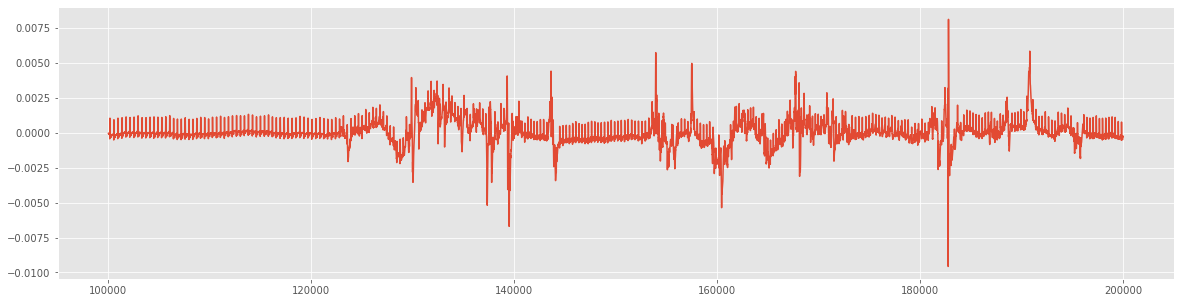

In [56]:
filt_sample = df['ECG'][100000:200000]
filt_time = df['timestamp'][100000:200000]
plt.figure(figsize=(20,5))
plt.plot(filt_sample)
plt.savefig("ECG")
plt.show()

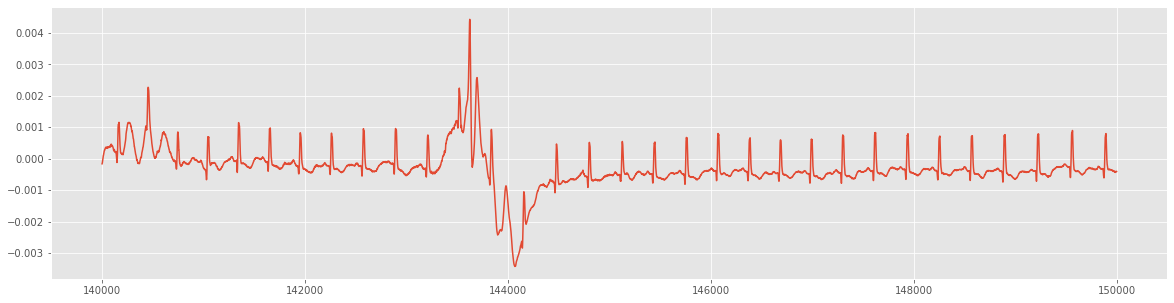

In [32]:
plt.figure(figsize=(20,5))
plt.plot(filt_sample[40000: 50000])
plt.show()

In [33]:
def butter_highpass_filter(data, cutoff, fs, order=6):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    y = signal.filtfilt(b, a, data)
    return y

def butter_bandstop_filter(data, lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    i, u = signal.butter(order, [low, high], btype='bandstop')
    y = signal.lfilter(i, u, data)
    return y

def butter_bandpass_filter(data, lowcut, highcut, fs, order=1):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='bandpass')
    y = signal.filtfilt(b, a, data)
    return y

In [34]:
def rad_sample_to_hz(x, fs):
    return (x*fs)/(2*np.pi)

In [35]:
def ax_plot_filter(b, a, ax, fs):
    w, h = signal.freqz(b, a, worN=256*2, whole=False)
    ax.plot(rad_sample_to_hz(w, fs), abs(h), linewidth=3)

In [62]:
def notch_filter(data, cutoff, q, fs=500):
    nyq = 0.5*fs
    freq = cutoff/nyq
    b, a = signal.iirnotch(freq, q)
    z = signal.lfilter(b, a, data)
    return z

def apply_notch():
    pass

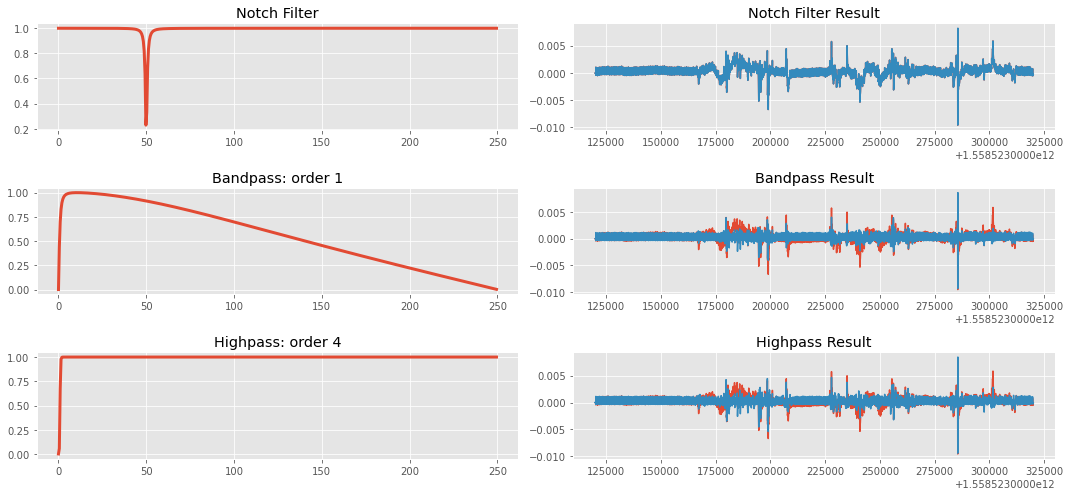

In [65]:
fig, axs = plt.subplots(3, 2, figsize=(15,7))

axs[0][0].set_title("Notch Filter")
b, a = signal.iirnotch(50, 30, 500)
ax_plot_filter(b, a, axs[0][0], ECG_FREQ)

axs[0][1].set_title("Notch Filter Result")
axs[0][1].plot(filt_time, filt_sample, label="Original")
axs[0][1].plot(filt_time, notch_filter(filt_sample, 50, 30), label="filtered")


axs[1][0].set_title("Bandpass: order 1")
b, a = signal.butter(1, [1, 98], btype='bandpass', analog=False, fs=ECG_FREQ)
ax_plot_filter(b, a, axs[1][0], ECG_FREQ)

axs[1][1].set_title("Bandpass Result")
axs[1][1].plot(filt_time, filt_sample, label="Original")
axs[1][1].plot(filt_time, butter_bandpass_filter(filt_sample, 1, 98, 500, order=4))


axs[2][0].set_title("Highpass: order 4")
b, a = signal.butter(4, 1, btype='high', analog=False, fs=ECG_FREQ)
ax_plot_filter(b, a, axs[2][0], ECG_FREQ)

axs[2][1].set_title("Highpass Result")
axs[2][1].plot(filt_time, filt_sample, label="Original")
axs[2][1].plot(filt_time, butter_highpass_filter(filt_sample, 0.5, 500, order=4))

plt.tight_layout()
plt.savefig("filterimpact")
plt.show()

As we can see there is minor power line noise in this signal. However here the highpass filter for low frequency drift greatly improves the signal quality

In [68]:
def apply_ecg_filter(series, FREQ):
    series = notch_filter(series, 50, 30, fs=FREQ)
    series = butter_highpass_filter(series, 1, FREQ, order=4)
    series = butter_bandpass_filter(series, 1, 98, FREQ)
    return series

In [45]:
f_filt_sample = apply_ecg_filter(filt_sample, ECG_FREQ)

<Figure size 720x360 with 0 Axes>

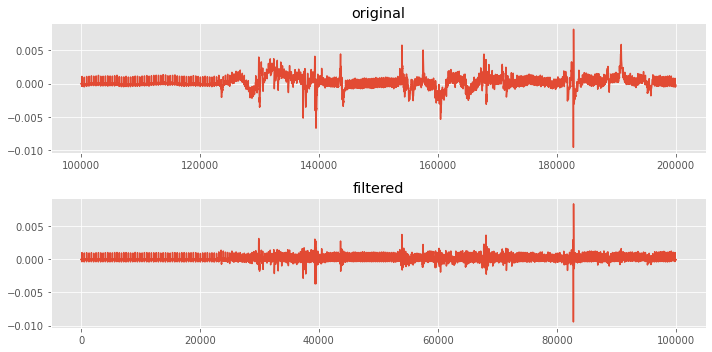

In [47]:
plt.figure(figsize=(10,5), facecolor='w')
fig, axs = plt.subplots(2,  figsize=(10,5), facecolor='w')

axs[0].plot(filt_sample)
axs[0].set_title("original")

axs[1].plot(f_filt_sample)
axs[1].set_title("filtered")

my_x_ticks = ['start', "end"]
#plt.xticks([0, len(eeg_df['CH-1'])], my_x_ticks)
fig.tight_layout()
plt.savefig("Channelspatient4")
plt.show()


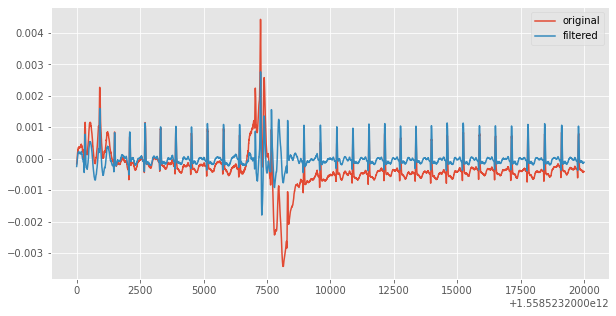

In [67]:
plt.figure(figsize=(10,5), facecolor='w')
plt.plot(filt_time[40000: 50000], filt_sample[40000: 50000], label="original")
plt.plot(filt_time[40000: 50000], f_filt_sample[40000: 50000], label="filtered")The 
plt.legend()
plt.savefig("zoomedecgfilter")
plt.show()

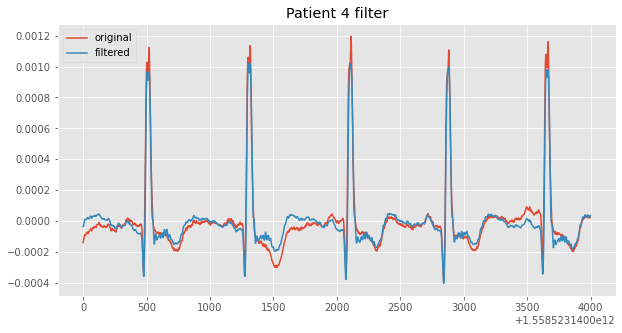

In [54]:
plt.figure(figsize=(10,5), facecolor='w')
plt.plot(filt_time[10000:12000], filt_sample[10000:12000], label="original")
plt.plot(filt_time[10000:12000], f_filt_sample[10000:12000], label="filtered")
plt.title("Patient 4 filter")
plt.legend()
plt.show()

## Frequency View

The spectrograms follows the same procedure as the EEG analysis

In [69]:
filt_ECG = apply_ecg_filter(df['ECG'], 500)

f, Pxx_den = signal.welch(filt_ECG, 500)

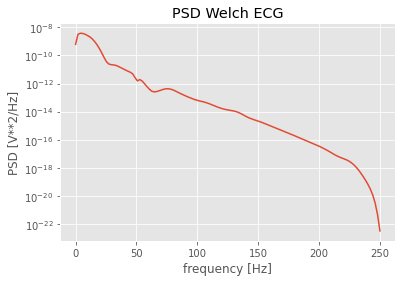

In [72]:
plt.semilogy(f, Pxx_den)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.title("PSD Welch ECG")
plt.savefig("WelchECG")
plt.show()

In [73]:
def nanpow2db(y):
    if isinstance(y, int) or isinstance(y, float):
        if y == 0:
            return np.nan
        else:
            ydB = 10 * np.log10(y)
    else:
        if isinstance(y, list):  # if list, turn into array
            y = np.asarray(y)
        y = y.astype(float)  # make sure it's a float array so we can put nans in it
        y[y == 0] = np.nan
        ydB = 10 * np.log10(y)

    return ydB

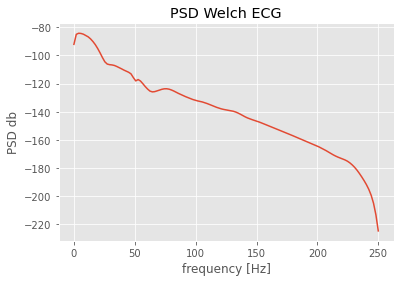

In [78]:
Pxx_db = nanpow2db(Pxx_den)
plt.plot(f, Pxx_db)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD db')
plt.title("PSD Welch ECG")
plt.savefig("WelchECG")
plt.show()

In [128]:
w_min = np.min(Pxx_den)
w_max = np.max(Pxx_den)
w_min_db = np.min(Pxx_db)
w_max_db = np.max(Pxx_db)

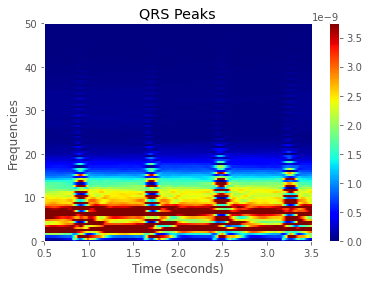

In [101]:
normalize_color= matplotlib.colors.Normalize(vmin=w_min, vmax=w_max)
f, t, Sxx = signal.spectrogram(np.array(f_filt_sample[10000:12000]), fs=500, nperseg=int(500), noverlap=int((500)*0.99), nfft=1024, scaling='density', return_onesided=True)
plt.pcolormesh(t, f, Sxx, cmap='jet', norm=normalize_color)
plt.colorbar()
plt.ylim(0,50)
plt.title("QRS Peaks")
plt.ylabel("Frequencies")
plt.xlabel("Time (seconds)")
plt.savefig("QRSSPEC")

plt.show()

Reading already filtered signals and plotting the different classes.

In [107]:
prei_df = pd.read_csv("/Users/niklashjort/Desktop/Notes/Speciale/projects/Dataset/EMU_monitor(ruc)/NHR/ECG/Preictal/Preictal_4_patient_4_date_2019-05-20 1102590000.csv", usecols=['ECG'])

sz_df = pd.read_csv("/Users/niklashjort/Desktop/Notes/Speciale/projects/Dataset/EMU_monitor(ruc)/NHR/ECG/Seizure/Seizure_1_patient_4_date_2019-05-20 1102590000.csv", usecols=['ECG'])

int_df = pd.read_csv("/Users/niklashjort/Desktop/Notes/Speciale/projects/Dataset/EMU_monitor(ruc)/NHR/ECG/Interictal/PostInt_1_patient_4_date_2019-05-20 1102590000.csv", usecols=['ECG'])

In [110]:
sz_df.head()

,ECG
0,-0.000074
1,-0.000083
2,-0.000094
3,-0.000103
4,-0.000109


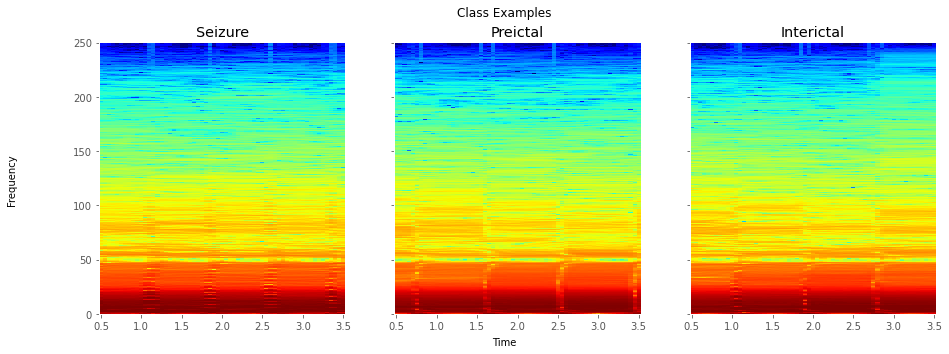

In [143]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5), sharey=True)

normalize_color= matplotlib.colors.Normalize(vmin=w_min_db, vmax=w_max_db)

ax1.set_title("Seizure")
f, t, Sxx = signal.spectrogram(sz_df['ECG'][1000:3000], fs=500, nperseg=int(500), noverlap=int((500)*0.95), nfft=1024, scaling='density', return_onesided=True)
Sxx = nanpow2db(Sxx)
ax1.pcolormesh(t, f, Sxx, cmap='jet', norm=normalize_color)


ax2.set_title("Preictal")
f, t, Sxx = signal.spectrogram(prei_df['ECG'][1000:3000], fs=500, nperseg=int(500), noverlap=int((500)*0.95), nfft=1024, scaling='density', return_onesided=True)
Sxx = nanpow2db(Sxx)
ax2.pcolormesh(t, f, Sxx, cmap='jet', norm=normalize_color)


ax3.set_title("Interictal")
f, t, Sxx = signal.spectrogram(int_df['ECG'][1000:3000], fs=500, nperseg=int(500), noverlap=int((500)*0.95), nfft=1024, scaling='density', return_onesided=True)
Sxx = nanpow2db(Sxx)
ax3.pcolormesh(t, f, Sxx, cmap='jet', norm=normalize_color)


fig.text(0.5, 0.04, 'Time', ha='center')
fig.text(0.04, 0.5, 'Frequency', va='center', rotation='vertical')
fig.suptitle('Class Examples')
plt.savefig("ecgclassex")
plt.show()

